In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from tqdm.notebook import tqdm

import plotly
import plotly.graph_objs as go
import plotly.express as px
from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

from DataManager import DataManager
import seaborn as sns

In [3]:
dm =  DataManager()

In [4]:
scaler = StandardScaler()
ftr_data = scaler.fit_transform(dm.data.values[:,3:])
ftr_data = dm.data.values[:,3:]

In [5]:
cell_n_matrix = np.zeros((1372, 12))

In [6]:
for drug, cell_line in itertools.product(range(1372), range(12)):
    nn = dm.data[(dm.data["drug"]==drug)&(dm.data["cell_line"]==cell_line)]["n"].mean()
    cell_n_matrix[drug, cell_line] = nn

In [7]:
def objective_function(X, U, V, R, alpha=0.1, l1_ratio=0.2, residual_l1_ratio=0.8, beta=2.0):
    assert 0<=l1_ratio<=1
    residual = X - R - np.dot(U, V.T)
    sqe = np.sum(np.multiply(residual, residual))
    l1 = alpha * l1_ratio * (np.sum(np.abs(U)) + np.sum(np.abs(V)))
    l2 = alpha * (1-l1_ratio) * (np.sum(np.multiply(U, U)) + np.sum(np.multiply(V, V)))
    residual_l1 = beta * residual_l1_ratio * np.sum(np.abs(R))
    residual_l2 = beta * (1-residual_l1_ratio) * np.sum(np.multiply(R, R))
    return sqe + l1 + l2 + residual_l1 + residual_l2
    
def grad_R(X, U, V, R, beta=2.0):
    sqe_grad = -2 * (X - R - np.dot(U, V.T))
    l1_residual_grad = beta * residual_l1_ratio * np.multiply(np.sign(R), R)
    l2_residual_grad = beta * (1-residual_l1_ratio) * 2 * R
    return sqe_grad + l1_residual_grad * l2_residual_grad

def grad_U(X, U, V, R, alpha=0.1, l1_ratio=0.2):
    l1_grad = alpha * l1_ratio * np.multiply(np.sign(U), U)
    l2_grad = alpha * (1-l1_ratio) * 2 * U
    sqe_grad = -2 * np.dot(X - R - np.dot(U, V.T), V)
    return l1_grad + l2_grad + sqe_grad

def grad_V(X, U, V, R, alpha=0.1, l1_ratio=0.2):
    l1_grad = alpha * l1_ratio * np.multiply(np.sign(V), V)
    l2_grad = alpha * (1-l1_ratio) * 2 * V
    sqe_grad = -2 * np.dot((X - R - np.dot(U, V.T)).T, U)
    return l1_grad + l2_grad + sqe_grad

In [8]:
def matrix_factorisation(X, latent_dim, lr, alpha, beta, l1_ratio, residual_l1_ratio, n_iter=100):
    centering = np.mean(X)
    X = X - centering
    U = np.random.randn(X.shape[0], latent_dim)    
    V = np.random.randn(X.shape[1], latent_dim)
    R = np.random.randn(*X.shape)
    
    losses = []
    for i in tqdm(range(n_iter)):
        loss = objective_function(X, U, V, R, alpha, l1_ratio, beta)
        losses.append(loss)
        
        gU = grad_U(X, U, V, R, alpha, l1_ratio)
        U = U - lr*gU
        
        gV = grad_V(X, U, V, R, alpha, l1_ratio)
        V = V - lr*gV

        gR = grad_R(X, U, V, R, beta)
        R = R - lr*gR
    loss = objective_function(X, U, V, R, alpha, l1_ratio, beta)
    losses.append(loss)
    return losses, U, V, R

In [9]:
latent_dim = 10
lr = 0.001
alpha = 1
beta = 5
l1_ratio = 0.1
residual_l1_ratio = 1
# losses, drug_mat, cl_mat, residual_mat = matrix_factorisation(cell_n_matrix, latent_dim, lr, 
#                                                               alpha, beta, l1_ratio, residual_l1_ratio,
#                                                               n_iter = 300)

# plt.plot(losses)

In [10]:
# fig = go.Figure(data=go.Heatmap(
#                    z=residual_mat,
#                    x=dm.cell_line_df["mutation"],
#                    y=dm.drug_df["Name"],
#                    hoverongaps = False))
# fig.update_layout(
#     width=800,
#     height=2600)
# fig.update_xaxes(side="top")
# fig.show()

In [11]:
column_medians = np.median(cell_n_matrix, axis=0)
median_centered_n = cell_n_matrix - column_medians
row_medians = np.median(median_centered_n, axis = 1)
median_centered_n = (median_centered_n.T - row_medians).T

In [12]:
median_centered_n

array([[ 0.09100158, -0.13349017, -0.19050347, ..., -0.27616904,
        -0.00986242, -0.02514816],
       [ 0.067254  ,  0.05606344, -0.15058481, ..., -0.10081461,
        -0.08446299, -0.03980521],
       [ 0.00116715, -0.0086449 , -0.13926484, ..., -0.04974213,
        -0.11342605,  0.01962625],
       ...,
       [-0.01779732, -0.03046339, -0.12445287, ..., -0.06912201,
         0.07911012, -0.11344561],
       [-0.04992753, -0.00366298, -0.17953266, ...,  0.12867851,
         0.02441744, -0.09411151],
       [ 0.05728333,  0.01302359, -0.09458265, ...,  0.04515237,
        -0.01302359, -0.05969505]])

In [13]:
centered_n_matrix = cell_n_matrix - np.median(cell_n_matrix)

In [14]:
np.median(cell_n_matrix)

12.686414139320767

In [32]:
svd = TruncatedSVD(n_components=10, n_iter=20, random_state=42)
drugs_mat = svd.fit_transform(centered_n_matrix)
cl_mat = svd.components_
reconstruction = np.dot(drugs_mat, cl_mat)
residuals = (centered_n_matrix-reconstruction)
print("SVD reconstruction error: {}".format(np.linalg.norm(residuals)))

SVD reconstruction error: 3.30221888903327


In [33]:
np.where(residuals<0)

(array([   0,    0,    0, ..., 1371, 1371, 1371]),
 array([ 1,  4,  6, ...,  3,  5, 11]))

In [34]:
fig = go.Figure(data=go.Heatmap(
                   z=residuals,
                   x=dm.cell_line_df["mutation"],
                   y=dm.drug_df["Name"],
                   hoverongaps = False),
                layout=go.Layout(
        title=go.layout.Title(text="SVD residuals for number of cells")
    ))
               
fig.update_layout(
    width=800,
    height=3600)
fig.update_xaxes(side="top")
fig.show()

In [17]:
fig = go.Figure(data=go.Heatmap(
                   z=cl_mat.T,
                   x=list(range(cl_mat.T.shape[1])),
                   y=dm.cell_line_df["mutationDetailed"],
                   hoverongaps = False),
                layout=go.Layout(
        title=go.layout.Title(text="SVD embeddings of mutations")
    ))
fig.update_layout(
    width=800,
    height=1000)
fig.update_xaxes(side="top")
fig.show()

In [18]:
fig = go.Figure(data=go.Heatmap(
                   z=drugs_mat,
                   x=list(range(drugs_mat.shape[1])),
                   y=dm.drug_df["Name"],
                   hoverongaps = False),
                layout=go.Layout(
        title=go.layout.Title(text="SVD embeddings of drugs")
    ))
fig.update_layout(
    width=800,
    height=3600)
fig.update_xaxes(side="top")
fig.show()

In [35]:
nmf = NMF(n_components=10, init='random', random_state=0)
drugs_mat = nmf.fit_transform(cell_n_matrix)
cl_mat = nmf.components_
reconstruction = np.dot(drugs_mat, cl_mat)
residuals = (cell_n_matrix-reconstruction)
print("NMF reconstruction error: {}".format(np.linalg.norm(residuals)))

NMF reconstruction error: 7.044317115256297


In [36]:
residuals

array([[-0.02117256,  0.01857652, -0.05380487, ..., -0.14936795,
        -0.07620026,  0.10844816],
       [-0.02626248,  0.04381373, -0.0185653 , ..., -0.07654883,
        -0.09825205,  0.04395004],
       [-0.03608948,  0.03810989, -0.00536457, ..., -0.06364979,
        -0.13847939,  0.08935043],
       ...,
       [-0.00542338,  0.02485461,  0.00103283, ..., -0.04815498,
         0.00894013, -0.01061359],
       [ 0.01382057, -0.02351693, -0.0582114 , ...,  0.13266693,
         0.03603543, -0.01510983],
       [-0.00242153,  0.00685225, -0.00946614, ...,  0.03172399,
         0.00670797, -0.04014949]])

In [37]:
fig = go.Figure(data=go.Heatmap(
                   z=residuals,
                   x=dm.cell_line_df["mutation"],
                   y=dm.drug_df["Name"],
                   hoverongaps = False),
                layout=go.Layout(
        title=go.layout.Title(text="NMF residuals for number of cells")
    ))
               
fig.update_layout(
    width=800,
    height=3600)
fig.update_xaxes(side="top")
fig.show()

In [41]:
fig = go.Figure(data=go.Heatmap(
                   z=residuals[1000:1100,:],
                   x=dm.cell_line_df["mutation"],
                   y=dm.drug_df["Name"][1000:1100],
                   hoverongaps = False),
                layout=go.Layout(
        title=go.layout.Title(text="NMF residuals for number of cells")
    ))
               
fig.update_layout(
    width=800,
    height=1000)
fig.update_xaxes(side="top")
fig.show()

In [22]:
fig = go.Figure(data=go.Heatmap(
                   z=cl_mat.T,
                   x=list(range(cl_mat.T.shape[1])),
                   y=dm.cell_line_df["mutationDetailed"],
                   hoverongaps = False),
                layout=go.Layout(
        title=go.layout.Title(text="NMF embeddings of mutations")
    ))
fig.update_layout(
    width=800,
    height=1000)
fig.update_xaxes(side="top")
fig.show()

In [23]:
fig = go.Figure(data=go.Heatmap(
                   z=drugs_mat,
                   x=list(range(drugs_mat.shape[1])),
                   y=dm.drug_df["Name"],
                   hoverongaps = False))
fig.update_layout(
    width=800,
    height=3600)
fig.update_xaxes(side="top")
fig.show()

## Nearest drugs to mutations

In [24]:
from scipy.spatial import distance

def closest_node_sp(node, nodes):
    closest_index = distance.cdist([node], nodes).argmin()
    return closest_index

def closest_node_cos(node, nodes):
    closest_index = np.array([distance.cdist([node], [n]) for n in nodes]).argmin()
    return closest_index

def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    return np.argmin(dist_2)

In [25]:
repr_mat = []
y_axis = []
for cl in range(12):
    cl_name = dm.cell_line_df["mutationDetailed"].iloc[cl]
    cd_idx = closest_node_sp(cl_mat.T[cl,:], drugs_mat)
    closest_drug_name = dm.drug_df["Name"].iloc[cd_idx]
    if len(closest_drug_name) <1:
        closest_drug_name = dm.drug_df["Content"].iloc[cd_idx]
    y_axis.append("CL: "+cl_name)
    y_axis.append("Drug: "+closest_drug_name)
    repr_mat.append(cl_mat.T[cl,:])
    repr_mat.append(drugs_mat[cd_idx,:])
    print("CL: {} - Drug {}".format(cl_name, closest_drug_name))
repr_mat = np.array(repr_mat)

CL: AKT1-/-&AKT2-/- - Drug IC 261
CL: MEK2-/- - Drug Ganciclovir
CL: AKT1-/- - Drug Ganciclovir
CL: CTNNB1 mt-/wt+ - Drug IC 261
CL: PARENTAL007 - Drug Palmitoylethanolamide
CL: P53-/- - Drug IC 261
CL: PTEN-/- - Drug IC 261
CL: PI3KCA mt-/wt+ - Drug Ganciclovir
CL: KRAS mt-/wt+ - Drug ctrl U0126
CL: BAX-/- - Drug IC 261
CL: MEK1-/- - Drug IC 261
CL: PARENTAL001 - Drug Palmitoylethanolamide


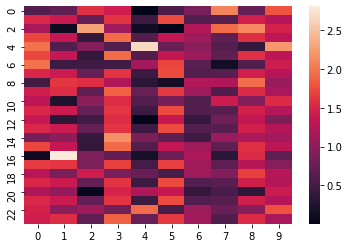

In [26]:

sns.heatmap(repr_mat)

## Toxicity interactions

In [27]:
samples_deviations = []
for i, j in itertools.product(range(residuals.shape[0]),range(residuals.shape[1])):
    samples_deviations.append((residuals[i,j], i, j))
    
samples_deviations = sorted(samples_deviations, key=lambda s: s[0])

In [28]:
samples_deviations[3]

(-0.4448759109273297, 1156, 3)

In [29]:
residuals

array([[-0.02117256,  0.01857652, -0.05380487, ..., -0.14936795,
        -0.07620026,  0.10844816],
       [-0.02626248,  0.04381373, -0.0185653 , ..., -0.07654883,
        -0.09825205,  0.04395004],
       [-0.03608948,  0.03810989, -0.00536457, ..., -0.06364979,
        -0.13847939,  0.08935043],
       ...,
       [-0.00542338,  0.02485461,  0.00103283, ..., -0.04815498,
         0.00894013, -0.01061359],
       [ 0.01382057, -0.02351693, -0.0582114 , ...,  0.13266693,
         0.03603543, -0.01510983],
       [-0.00242153,  0.00685225, -0.00946614, ...,  0.03172399,
         0.00670797, -0.04014949]])

In [30]:
original_interactions = []
for d, cl, r in itertools.product(range(1372), range(12), range(2)):
    original_interactions.append((dm.interactions["res"][d,cl,r,0], d, cl, r))
original_interactions = sorted(original_interactions, key=lambda s: s[0])
original_interactions = [dm.data[(dm.data["drug"]==s[1])&(dm.data["cell_line"]==s[2])&(dm.data["replicate"]==s[3])].index[0]
                        for s in original_interactions]


In [31]:
percentile=2
N = int(len(original_interactions)*percentile/100)
counter = 0
for k in range(N):
    res, i, j = samples_deviations[k]
    samples = dm.data[(dm.data["drug"]==i)&(dm.data["cell_line"]==j)].index.tolist()
    for idx in samples:
        if idx in original_interactions[:N]:
            counter += 1
print(counter, N)
print("Recall: {}".format(counter/N))

188 658
Recall: 0.2857142857142857
